In [75]:
import sys
# sys.path.insert(0, "./")
# sys.path.insert(0, "../../")
import torch
from torch.utils.data import Dataset
from utils import *
import random
import matplotlib.pyplot as plt

from torchvision.models import resnet50, resnet18
import argparse
import traceback
import seaborn as sns
import pandas as pd
import csv
import ast
import pdb
import utils

In [76]:
GRID_SIZE =10
time_out = 600


experiment_label ="BLOCKING_ONLY_EXHUASTIVE" 
base_data_dir = "./baselines/data" #"./data"


def extract_labels(folder_path, grid_size = 6):
    # Regular expression to match the pattern 'times_7_LABEL.csv'
    pattern = pattern = rf"times_{grid_size}_(.+)\.csv"
    # List to hold unique labels
    unique_labels = set()

    # Iterate over all files in the given folder
    for filename in os.listdir(folder_path):
        # Check if the filename matches the pattern
        match = re.match(pattern, filename)
        if match:
            # Extract the label and add to the set
            label = match.group(1)
            unique_labels.add(label)

    return list(unique_labels)

In [77]:
# for visualization purposes
display_label ={
    "BLOCKING_ONLY_EXHUASTIVE":"Exhaustive",
    "BLOCKING_ONLY_PRUNE_REDUCE": "Pruned-Reduce",
    "BLOCKING_ONLY_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "BLOCKING_ONLY_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "BLOCKING_ONLY_test":"Our approach",
    "ALL_MODS_EXHUASTIVE":"Exhaustive",
    "ALL_MODS_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "ALL_MODS_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "ALL_MODS_test":"Our approach",
    "BOTH_UNIFORM_EXHAUSTIVE":"Exhaustive",
    "BOTH_UNIFORM_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "BOTH_UNIFORM_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "BOTH_UNIFORM_test":"Our approach"
    
}
display_label_colors = {
    "BLOCKING_ONLY_EXHUASTIVE": "#1b9e77",  # A greenish color
    "BLOCKING_ONLY_PRUNE_REDUCE": "#d95f02",  # An orangish color
    "BLOCKING_ONLY_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "BLOCKING_ONLY_GREEDY_PRED_WCD": "#e7298a",  # A crimson-like pink color
    "BLOCKING_ONLY_test": "#66a61e",  # A grass green color
    "ALL_MODS_EXHUASTIVE": "#1b9e77",  # A golden color
    "ALL_MODS_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "ALL_MODS_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "ALL_MODS_test": "#66a61e",  # A grass green color
    "BOTH_UNIFORM_EXHAUSTIVE": "#1b9e77",  # A golden color
    "BOTH_UNIFORM_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "BOTH_UNIFORM_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "BOTH_UNIFORM_test": "#66a61e"  # A grass green color
}


In [78]:
def read_env_data(file_name):
    with open(file_name, "rb") as f:
        loaded_dataset = pickle.load(f)
        x_data = []
        y_data = []
        for i in range(loaded_dataset. __len__()):

            x_data.append(loaded_dataset[i][0].unsqueeze(0))
            y_data.append(loaded_dataset[i][1].unsqueeze(0))

        x_init_data = torch.cat(x_data).numpy()
        y_init_data = torch.cat(y_data).numpy()
        
    return x_init_data, y_init_data

def read_csv(filename):
    """
    Reads numbers from a CSV file and returns them as a list of lists.

    Args:
    filename (str): The name of the CSV file.

    Returns:
    list of lists: Each sublist contains numbers from a row in the CSV file.
    """
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert each string in the row to an integer
            number_row = [ast.literal_eval(item) for item in row]
            data.append(number_row)
    return data 
def display_init_final(x_init,y_init,x_final,y_final, start_from_idx =0, display_interval = 10):
    for idx in range(0,x_init.shape[0],display_interval):
        print(idx)
        x_i = x_init[idx]


        print("Init true WCD = ",y_init[idx])
        plot_grid(decode_grid_design(x_i,return_map= True).tolist())

        x_k = x_final[idx]

        print("Final WCD = ",y_final[idx])
        plot_grid(decode_grid_design(x_k,return_map= True).tolist())

        print("\n =========================")

In [79]:
def calculate_means_and_errors(data):
    """Calculate means and standard errors for each column."""
    means = np.mean(data, axis=0)
    stderr = np.std(data, axis=0, ddof=1) / np.sqrt(data.shape[0])
    return means, stderr

# Initialize DataFrames to store summary data
columns = ["Experiment Label","n",'mean', 'std_err',"given_budget", "realized_budget"]
time_summary = pd.DataFrame(columns=columns)
wcd_summary = pd.DataFrame(columns=columns)
percent_completed_summary = pd.DataFrame(columns=columns)
percent_reduced_summary = pd.DataFrame(columns=columns)

In [80]:
results_df = pd.DataFrame(columns=["Experiment Label","Grid Size","n","Mean Time (sd)", "Mean Time (s)",  "% Completed", "% Reduced", "Mean WCD Reduction (sd)","Mean WCD Reduction"])
experiment_labels = extract_labels(f"./data/grid{GRID_SIZE}/timeout_{time_out}", grid_size = GRID_SIZE )+ extract_labels(f"./baselines/data/grid{GRID_SIZE}/timeout_{time_out}", grid_size = GRID_SIZE)
experiment_labels = sorted(experiment_labels,reverse=False)

num_instances = 300
for experiment_label in experiment_labels:
    # if experiment_label == "BOTH_UNIFORM_test": continue
    if experiment_label in ["BLOCKING_ONLY_test","ALL_MODS_test","BOTH_UNIFORM_test"]:
        base_data_dir = f"./data/grid{GRID_SIZE}/timeout_{time_out}" #"./data"
    else:
        base_data_dir = f"./baselines/data/grid{GRID_SIZE}/timeout_{time_out}" #"./data"
        
    init_file_name = f"{base_data_dir}/initial_envs_{GRID_SIZE}_{experiment_label}.pkl"

    final_file_name = f"{base_data_dir}/final_envs_{GRID_SIZE}_{experiment_label}.pkl"

    times = read_csv(f'{base_data_dir}/times_{GRID_SIZE}_{experiment_label}.csv')
    budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
    wcd_change = read_csv(f'{base_data_dir}/wcd_change_{GRID_SIZE}_{experiment_label}.csv')

    budget = np.array(budgets).flatten()
    time_raw = np.array(times)
    times = np.array(times)

    wcd_change = np.array(wcd_change)

    budget = np.array(budgets).flatten()
    times = np.array(times)
    wcd_change = np.array(wcd_change)
        
    # Store in DataFrames
    if experiment_label in ["ALL_MODS_test","BLOCKING_ONLY_test", "BOTH_UNIFORM_test"]:
        print(experiment_label)
        if experiment_label=="BLOCKING_ONLY_test": 
            n_lambda_pairs = 20
        elif experiment_label =="BOTH_UNIFORM_test": 
            n_lambda_pairs = 9
        else:
            n_lambda_pairs = 25
        budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
        budgets = np.array(budgets)
        max_budgets = np.array(read_csv(f'{base_data_dir}/max_budgets_{GRID_SIZE}_{experiment_label}.csv'))[0]
        
        wcd_change = np.array(wcd_change)[0:num_instances]
        times = times[0:num_instances]
        budgets = budgets[0:num_instances]
        

        # print(wcd_change)
        
        best_wcd_changes = []
        realized_budgets = []
        realized_budgets_times =[]
        given_budgets = []
        
        flattened_times = []
        flattened_wcd_changes = []
        flattened_realized_budgets = []
        flattened_given_budgets =[]
        n = times.shape[0]

        new_wcd_change = []
        new_budgets = []
        new_times = []
        for i in range(budgets.shape[0]):
            budget_buckets_wcd_change = wcd_change[i]
            budget_buckets_realized=budgets[i]
            budget_buckets_times = times[i]
            # print("Init:",budget_buckets_wcd_change)
            # print(budget_buckets_realized)
            for k in range(len(max_budgets)):
                if budgets[i][k] ==[]: continue
                # print(max_budgets[k])
                for j in range(k,len(max_budgets)):
                    if budget_buckets_wcd_change[k]>budget_buckets_wcd_change[j]:
                        budget_buckets_wcd_change[j] = budget_buckets_wcd_change[k]
                        budget_buckets_times[j]= budget_buckets_times[k]
                        budget_buckets_realized[j] = budget_buckets_realized[k]
            
            new_wcd_change.append(budget_buckets_wcd_change)
            new_budgets.append(budget_buckets_realized)
            new_times.append(budget_buckets_times)
            
            # print("Final:",budget_buckets_wcd_change)
            # print(budget_buckets_realized)
            
            
        
        budgets = np.array(new_budgets)
        wcd_change = np.array(new_wcd_change)
        times = np.array(new_times)
        
        for i in range(budgets.shape[0]):
            mask_ = wcd_change[i]>-100 # remove -100 WCD -- place holder
            
            flattened_realized_budgets.extend([np.sum(k) for k in budgets[i][mask_]])
            flattened_times.extend(times[i][mask_].flatten())
            flattened_wcd_changes.extend(wcd_change[i][mask_].flatten())
            flattened_given_budgets.extend(max_budgets[mask_].flatten())
        
        
        print("There are ",np.sum(np.array(flattened_given_budgets)==1), "Ones",budgets.shape[0])
        time_summary.loc[experiment_label] = [experiment_label,n,flattened_times, flattened_times,flattened_given_budgets, flattened_realized_budgets]
        wcd_summary.loc[experiment_label] = [experiment_label,n,flattened_wcd_changes, flattened_wcd_changes,flattened_given_budgets, flattened_realized_budgets]

        
    else:
        print(experiment_label)
     
        wcd_change= wcd_change[0:num_instances]# only envs that completed
        n = times.shape[0]

        realized_budgets = np.array(read_csv(f'{base_data_dir}/num_changes_{GRID_SIZE}_{experiment_label}.csv')).sum(axis =2)[0:num_instances]
        #.flatten()
        given_budget = np.array(read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')*n)[0:num_instances]
        times= times[0:num_instances]
        
        n = times.shape[0]
        # print(times.shape, wcd_change.shape,realized_budgets.shape)
        time_summary.loc[experiment_label] = [experiment_label,n,times.flatten(), times.flatten(),given_budget.flatten(),realized_budgets.flatten()]
        wcd_summary.loc[experiment_label] = [experiment_label,n,wcd_change.flatten(), wcd_change.flatten(),given_budget.flatten(),realized_budgets.flatten()]
        


from scipy.interpolate import make_interp_spline
from scipy.ndimage import uniform_filter1d
def moving_average(data, window_size):
    return uniform_filter1d(data, size=window_size, mode='reflect')

def plot_summary(df, ylabel, title, show_std_err=True, filename=None, use_given_budget=True, smoothing_window=4,use_log_scale = False, show_title=False):
    for label, row in df.iterrows():
        data = pd.DataFrame({
            'budget': row['given_budget'] if use_given_budget else row['realized_budget'],
            'mean': row['mean']
        })
        
        print(label)
        
        timeout_data = data.groupby('budget')['mean'].agg(['count', lambda x: (x >=time_out).sum()]).reset_index()
        timeout_data.columns = ['budget', 'total_count', 'count_timeout']

        # Calculate percentage for each budget
        timeout_data['percentage_timeout'] = (timeout_data['count_timeout'] / timeout_data['total_count']) * 100

        
            
        # Group by 'budget' and calculate standard error of the mean
        grouped_data = data.groupby('budget')['mean'].agg(['mean', 'sem', "count"]).reset_index()
        
        if use_log_scale:
            grouped_data['sem'] = grouped_data['sem'] / grouped_data['mean']
            grouped_data["mean"] = np.log10(grouped_data["mean"])
            
        grouped_data = grouped_data[grouped_data["budget"] < 20]
        grouped_data = grouped_data[grouped_data["count"] > 1]
        grouped_data
            
        # Apply smoothing if specified
        if smoothing_window:
            grouped_data['mean'] = moving_average(grouped_data['mean'], smoothing_window)
        
        
        legend_label = f"{display_label[label]}" #f"{display_label[label]}(n={row['n']})"
        # legend_label = f"{display_label[label]}(n={row['n']})"
            # Plot error bars
        plt.errorbar(grouped_data['budget'], grouped_data['mean'], yerr=grouped_data['sem'], fmt='-o',
                         capsize=1, label=legend_label, color=display_label_colors[label])
        if show_std_err:
            plt.fill_between(grouped_data["budget"], grouped_data['mean'] - grouped_data['sem'],
                             grouped_data['mean'] + grouped_data['sem'], alpha=0.2, color=display_label_colors[label])

    plt.xlabel("budget",fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if show_title:
        plt.title(title)
    plt.legend(fontsize=10)
    
    plt.xticks(range(int(min(grouped_data['budget'])), int(max(grouped_data['budget'])) + 1,2))

    if filename:
        folder_path = "./plots/"
        # Check if the folder exists, create it if not
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            os.makedirs(folder_path+"/time")
            os.makedirs(folder_path+"/wcd_reduction")
            print(f"Created folder: {folder_path}")
            
        plt.savefig(f"{folder_path}{filename}", dpi=500,bbox_inches='tight')

    plt.show()
    

BLOCKING_ONLY_GREEDY_TRUE_WCD
BOTH_UNIFORM_GREEDY_TRUE_WCD


In [81]:
time_summary_uniform_df = time_summary[time_summary['Experiment Label'].str.contains("UNIFORM")]
wcd_summary_uniform_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("UNIFORM")]

# Splitting the DataFrame based on experiment labels
time_summary_blocking_df = time_summary[time_summary['Experiment Label'].str.contains("BLOCKING")]
wcd_summary_blocking_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("BLOCKING")]


time_summary_all_mods_df = time_summary[time_summary['Experiment Label'].str.contains("ALL_MODS")]
wcd_summary_all_mods_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("ALL_MODS")]


In [82]:
use_given_budget = True
smoothing_window=2
show_title = False
file_type = ".pdf"

BLOCKING_ONLY_GREEDY_TRUE_WCD


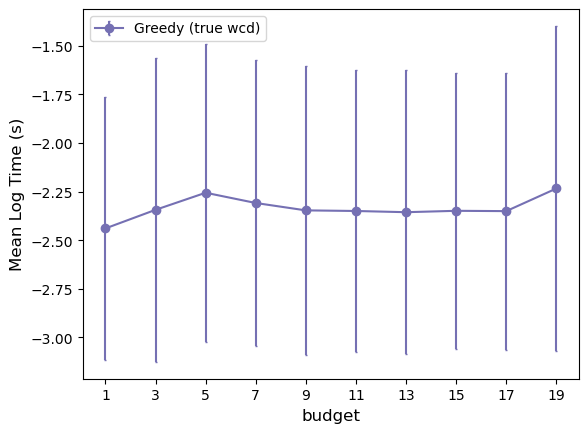

BLOCKING_ONLY_GREEDY_TRUE_WCD


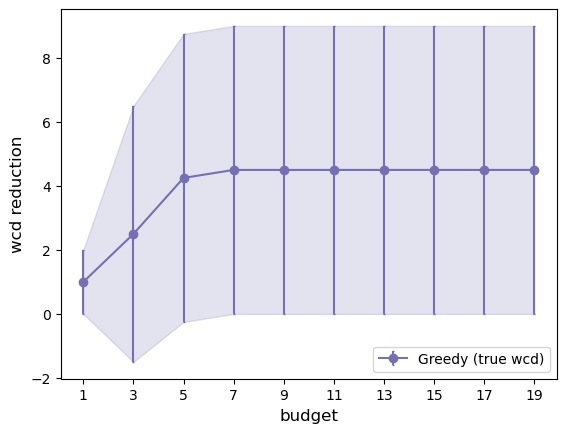

In [83]:
# Plotting Time
plot_summary(time_summary_blocking_df, 'Mean Log Time (s)', f'Blocking Only',
             use_given_budget = use_given_budget, show_std_err= False,show_title=show_title,
             filename =f"time/time_{GRID_SIZE}_{time_out}_blocking.{file_type}",use_log_scale = True,smoothing_window=smoothing_window)

# Plotting WCD Change
plot_summary(wcd_summary_blocking_df, 'wcd reduction', f'Blocking only',
             use_given_budget = use_given_budget,show_title=show_title,
            filename =f"wcd_reduction/reduction_{GRID_SIZE}_{time_out}_blocking.{file_type}",smoothing_window=smoothing_window)

BOTH_UNIFORM_GREEDY_TRUE_WCD


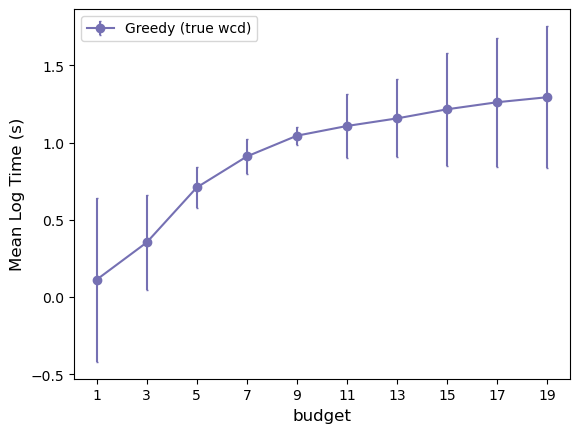

BOTH_UNIFORM_GREEDY_TRUE_WCD


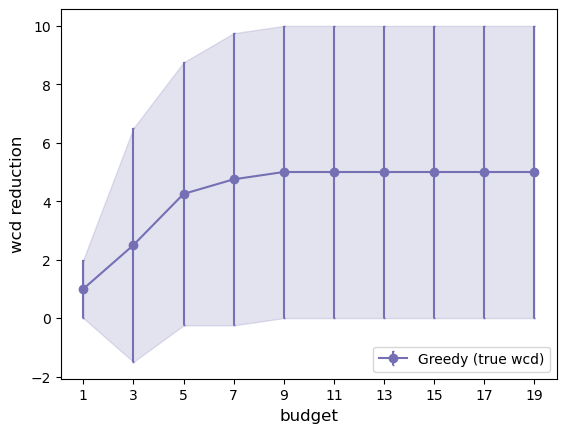

In [84]:
plot_summary(time_summary_uniform_df, 'Mean Log Time (s)', f'Uniform Modifications',
             use_given_budget = use_given_budget,show_std_err= False,show_title=show_title,
            filename =f"time/time_{GRID_SIZE}_{time_out}_uniform_cost.{file_type}",use_log_scale = True,smoothing_window=smoothing_window)

# Plotting WCD Change
plot_summary(wcd_summary_uniform_df, 'wcd reduction', f'Uniform Modifications',
             use_given_budget = use_given_budget, show_title=show_title,
            filename =f"wcd_reduction/reduction_{GRID_SIZE}_{time_out}_uniform_cost.{file_type}",smoothing_window=smoothing_window)